# Mounting the google drive

In [7]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Import all necessary modules

In [8]:
import torch
import os
import torchvision.utils
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torch.utils.data as td
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
from torchvision.io import read_image
from torchvision.models import resnet50, ResNet50_Weights
from matplotlib import image
from matplotlib import pyplot
import time

## DataLoader and image splitting

In [ ]:
def image_preprocess(path, train_split, val_split, batch_size, inp_size):
  normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
  transform=transforms.Compose([transforms.Resize(inp_size), transforms.RandomHorizontalFlip(), 
                                transforms.CenterCrop(inp_size), transforms.ToTensor(), normalize])
  

  data = datasets.ImageFolder(root=path, transform=transform)
  # data2 = datasets.ImageFolder(root=path, transform=transform)
  # dataFinal = data + data2
  
  test_split = round((1-train_split-val_split), 2)
  print(test_split)
  data_length = len(data)

  print(data_length, int(train_split*data_length),int(val_split*data_length), int(test_split*data_length))

  # The no. of images in each split of train, val and test
  train_size, val_size, test_size = int(train_split*data_length), int(val_split*data_length),int(test_split*data_length)
  train_data, val_data, test_data = td.random_split(data, [train_size, val_size, test_size])

  # Create the data loaders
  train_loader = td.DataLoader(train_data,  batch_size=batch_size, 
                               shuffle=True, drop_last=False, pin_memory=True, num_workers=2)
  val_loader = td.DataLoader(val_data,  batch_size=batch_size, 
                             shuffle=True, drop_last=False, pin_memory=True, num_workers=2)
  test_loader = td.DataLoader(test_data, batch_size=batch_size, 
                              shuffle=True, drop_last=False, pin_memory=True, num_workers=2)
  
  return train_loader, val_loader, test_loader


In [ ]:
path="/content/drive/MyDrive/AI Final Project/eightClass"
train_loader, val_loader, test_loader = image_preprocess(path, 0.7, 0.1, 32, (32,32))

0.2
4000 2800 400 800


# Loader data plotted for visualizaion

In [ ]:

def plot_data_loader(loader, grid):
  fig, axes = plt.subplots(nrows=grid[0], ncols=grid[1], figsize=(6,6))
  dataiter = iter(loader)
  for i in range(grid[0]):
    for j in range(grid[1]):
      images, _ = dataiter.next()
      axes[i, j].imshow(np.transpose(images[0].numpy(), (1, 2, 0)))

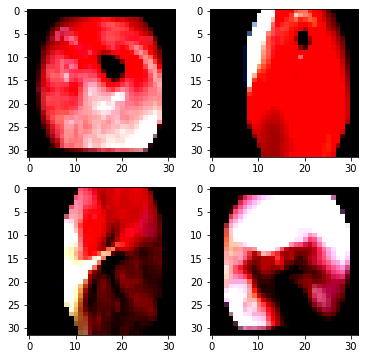

In [ ]:
plot_data_loader(train_loader, [2,2])




# Train function





In [ ]:
def train_model(model, train_loader, val_loader, optimizer, lossFunc, epochs=15):
    start = time.time()

    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print("Device: {}".format(device))

    best_model_weights = model.state_dict()
    best_accuracy = 0

    train_accuracy_list = []
    val_accuracy_list = []

    for epoch in range(1,epochs+1):

      for i, train_batch in enumerate(train_loader):
        images, labels, model = train_batch[0].to(device), train_batch[1].to(device), model.to(device)

        outputs = model(images)
        loss = lossFunc(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total = labels.size(0)
        _, predicted = torch.max(outputs.data, 1)
        correct = (predicted == labels).sum().item()

        for j, val_batch in enumerate(val_loader):
          images_, labels_ = val_batch[0].to(device), val_batch[1].to(device)
          outputs_ = model(images_)
          loss_ = lossFunc(outputs_, labels_)
          total_ = labels_.size(0)
          _,predicted_ = torch.max(outputs_.data, 1)
          correct_ = (predicted_ == labels_).sum().item()

        train_loss = loss.item()
        train_accuracy = (correct / total) * 100
        train_accuracy_list.append(train_accuracy)
        val_loss = loss_.item()
        val_accuracy = (correct_ / total_) * 100
        val_accuracy_list.append(val_accuracy)

        if val_accuracy > best_accuracy:
          best_accuracy = val_accuracy
          best_model_weights = model.state_dict()

        print("Epoch [{}/{}], Train_Loss: {:.4f}, Train_Accuracy: {:.2f}%  Val_Loss: {:.4f}, Val_Accuracy: {:.2f}%"
                .format(epoch, epochs, train_loss, train_accuracy, val_loss, val_accuracy))
      
    end = time.time()    
    print("######## Training Finished in {} seconds ###########".format(end-start))
    model.load_state_dict(best_model_weights)
    return model, best_model_weights, train_accuracy_list, val_accuracy_list

# ResNet50

In [ ]:
# Model definition and initialization
model = resnet50()
num_ftrs = model.fc.in_features
path = "/content/drive/MyDrive/AI Final Project/eightClass"
classes = os.listdir(path+"/")
model.fc = torch.nn.Linear(num_ftrs, len(classes))
optimizer = torch.optim.Adam(params=model.parameters())
loss = torch.nn.CrossEntropyLoss()

In [ ]:
resNet, best_model_dict, training_accuracy_list, val_accuracy_list = train_model(model, train_loader=train_loader, val_loader=val_loader, optimizer=optimizer, lossFunc=loss, epochs=20)

Device: cuda:0
Epoch [1/20], Train_Loss: 2.3960, Train_Accuracy: 12.50%  Val_Loss: 2.4044, Val_Accuracy: 25.00%
Epoch [1/20], Train_Loss: 3.2701, Train_Accuracy: 15.62%  Val_Loss: 2.3641, Val_Accuracy: 25.00%
Epoch [1/20], Train_Loss: 2.2650, Train_Accuracy: 28.12%  Val_Loss: 2.9623, Val_Accuracy: 6.25%
Epoch [1/20], Train_Loss: 2.2721, Train_Accuracy: 21.88%  Val_Loss: 1.9531, Val_Accuracy: 31.25%
Epoch [1/20], Train_Loss: 2.3796, Train_Accuracy: 25.00%  Val_Loss: 2.5205, Val_Accuracy: 25.00%
Epoch [1/20], Train_Loss: 2.3603, Train_Accuracy: 28.12%  Val_Loss: 2.7882, Val_Accuracy: 25.00%
Epoch [1/20], Train_Loss: 2.5540, Train_Accuracy: 34.38%  Val_Loss: 3.4430, Val_Accuracy: 18.75%
Epoch [1/20], Train_Loss: 2.6800, Train_Accuracy: 21.88%  Val_Loss: 2.6595, Val_Accuracy: 31.25%
Epoch [1/20], Train_Loss: 2.5495, Train_Accuracy: 31.25%  Val_Loss: 2.8793, Val_Accuracy: 12.50%
Epoch [1/20], Train_Loss: 1.7253, Train_Accuracy: 46.88%  Val_Loss: 2.5598, Val_Accuracy: 12.50%
Epoch [1/20], Tr

# Saving the weights, train and validation values

In [ ]:
checkpoint_resNet = {
    "model": resNet,
    "train_accuracy_list": training_accuracy_list,
    "val_accuracy_list": val_accuracy_list,
    "state_dict": resNet.state_dict()
}

torch.save(checkpoint_resNet, "/content/drive/MyDrive/AI Final Project/resNet50.pth")

In [ ]:
def load_checkpoint(filepath):
    '''
      Loads the saved dictionary with model data
    '''
    checkpoint = torch.load(filepath)
    return checkpoint

# Testing on a trained ResNet model

In [ ]:
model.eval() 
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model2 = model.to(device)
with torch.no_grad(): 
    correct = 0
    total = 0
    for data in test_loader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = model2(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    print('Test Accuracy of the model on the {} test images: {} %'
        .format(total, (correct / total) * 100))

Test Accuracy of the model on the 800 test images: 64.0 %


In [ ]:
def accuracyForEachEpoch(accuracy_list):
    accuracy = []
    sum = 0
    for i, v in enumerate(accuracy_list):

        if((i+1)%88==0):
            accuracy.append(sum/88)
            sum = 0
        else: 
            sum += v

    return accuracy

In [ ]:
train_accuracy, val_accuracy = accuracyForEachEpoch(training_accuracy_list), accuracyForEachEpoch(val_accuracy_list)

In [ ]:
def train_val_comparison(train_accuracy_list, val_accuracy_list, loader_length):
    x = np.linspace(0, 20, num=20)
    plt.figure(figsize=(20,5))
    plt.plot(x, train_accuracy_list, label="Train")
    plt.plot(x, val_accuracy_list, label="Validation")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.title("Train vs Validation")
    plt.legend()

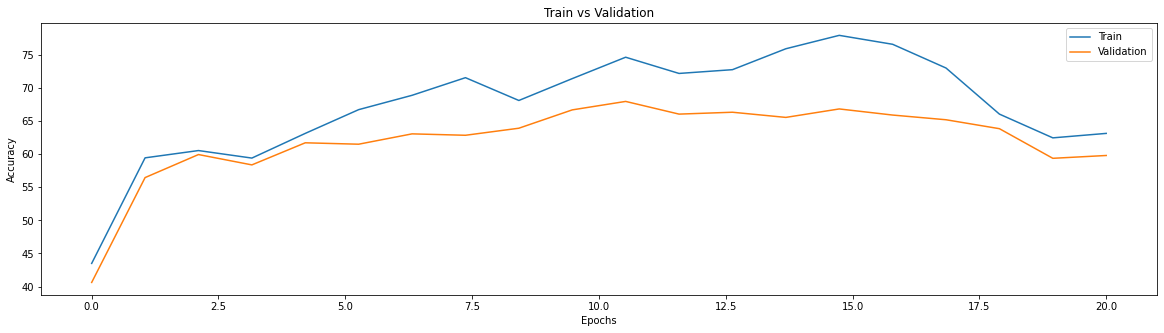

In [ ]:
train_val_comparison(train_accuracy, val_accuracy, len(train_loader))

# Transfer learning on ResNet50 

In [ ]:
## transfer learning
weights = ResNet50_Weights.DEFAULT
model = resnet50(weights=weights)
num_ftrs = model.fc.in_features
path = "/content/drive/MyDrive/Colab Notebooks/AI_lab/AI Final Project/newEightClass"
classes = os.listdir(path+"/")
model.fc = torch.nn.Linear(num_ftrs, len(classes))
optimizer = torch.optim.Adam(params=model.parameters())
loss = torch.nn.CrossEntropyLoss()

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

In [ ]:
best_model, best_model_dict, training_accuracy_list, val_accuracy_list = train_model(model, train_loader=train_loader, val_loader=val_loader, optimizer=optimizer, lossFunc=loss, epochs=20)

Device: cpu
Epoch [1/20], Train_Loss: 2.1056, Train_Accuracy: 15.62%  Val_Loss: 2.1107, Val_Accuracy: 6.25%
Epoch [1/20], Train_Loss: 2.1967, Train_Accuracy: 12.50%  Val_Loss: 1.9500, Val_Accuracy: 25.00%
Epoch [1/20], Train_Loss: 2.0299, Train_Accuracy: 21.88%  Val_Loss: 2.0545, Val_Accuracy: 18.75%
Epoch [1/20], Train_Loss: 2.0816, Train_Accuracy: 15.62%  Val_Loss: 1.9225, Val_Accuracy: 31.25%
Epoch [1/20], Train_Loss: 2.1073, Train_Accuracy: 21.88%  Val_Loss: 2.0398, Val_Accuracy: 18.75%
Epoch [1/20], Train_Loss: 1.9940, Train_Accuracy: 40.62%  Val_Loss: 1.9405, Val_Accuracy: 31.25%
Epoch [1/20], Train_Loss: 1.9359, Train_Accuracy: 28.12%  Val_Loss: 1.9402, Val_Accuracy: 25.00%
Epoch [1/20], Train_Loss: 1.9357, Train_Accuracy: 43.75%  Val_Loss: 2.0438, Val_Accuracy: 12.50%
Epoch [1/20], Train_Loss: 2.0315, Train_Accuracy: 28.12%  Val_Loss: 1.7715, Val_Accuracy: 62.50%
Epoch [1/20], Train_Loss: 1.9009, Train_Accuracy: 50.00%  Val_Loss: 1.8639, Val_Accuracy: 37.50%
Epoch [1/20], Train

# Saving weights, train and validation values

In [ ]:
resNet_tl = {
    "model": best_model,
    "state_dict": best_model.state_dict(),
    "train_accuracy_list": training_accuracy_list,
    "val_accuracy_list": val_accuracy_list
}

torch.save(resNet_tl, "/content/drive/MyDrive/Colab Notebooks/AI_lab/AI Final Project/resNet50_tl.pth")

In [ ]:
def accuracyForEachEpoch(accuracy_list):
    '''
      Converts data per steps into data per epochs
    '''
    accuracy = []
    sum = 0
    for i, v in enumerate(accuracy_list):

        if((i+1)%88==0):
            accuracy.append(sum/88)
            sum = 0
        else: 
            sum += v

    return accuracy

In [ ]:
train_accuracy, val_accuracy = accuracyForEachEpoch(training_accuracy_list), accuracyForEachEpoch(val_accuracy_list)

In [ ]:
def train_val_comparison(train_accuracy_list, val_accuracy_list, loader_length):
    x = np.linspace(0, 20, num=20)
    plt.figure(figsize=(20,5))
    plt.plot(x, train_accuracy_list, label="Train")
    plt.plot(x, val_accuracy_list, label="Validation")
    plt.xlabel("epochs")
    plt.ylabel("Accuracy")
    plt.title("Train vs Validation")
    plt.legend()

Comparison between train and validation for ResNet50 with transfer learning. The graph suggests that there is some overfitting as there is a considerable generation gap

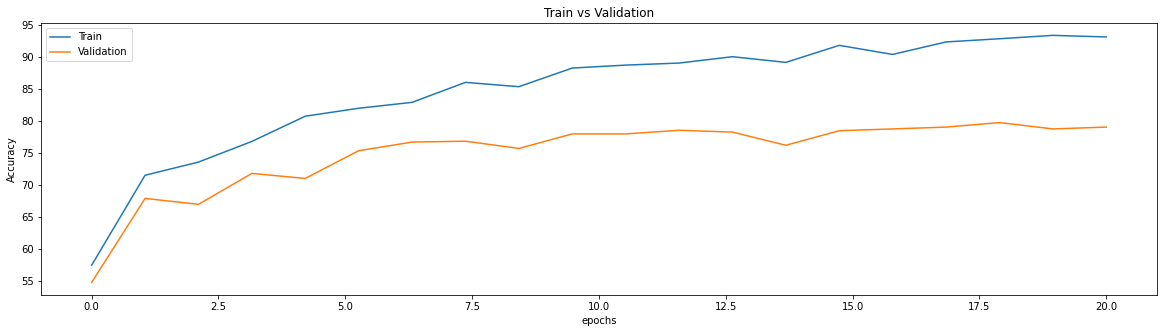

In [ ]:
train_val_comparison(train_accuracy, val_accuracy, len(train_loader))

# Evaluating our model on test_loader

In [ ]:
def load_checkpoint(filepath):
    checkpoint = torch.load(filepath)
    return checkpoint
checkpoint = load_checkpoint("/content/drive/MyDrive/Colab Notebooks/AI_lab/AI Final Project/resNet50_tl.pth")

In [ ]:
checkpoint.keys()

dict_keys(['model', 'state_dict'])

In [ ]:
model = resnet50()
num_ftrs = model.fc.in_features
path = "/content/drive/MyDrive/Colab Notebooks/AI_lab/AI Final Project/newEightClass"
classes = os.listdir(path+"/")
model.fc = torch.nn.Linear(num_ftrs, len(classes))
model.load_state_dict(checkpoint['state_dict'])
optimizer = torch.optim.Adam(params=model.parameters())
loss = torch.nn.CrossEntropyLoss()



In [ ]:
def evaluate_accuracy(model, test_loader):
  model.eval() 
  device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
  model2 = model.to(device)
  with torch.no_grad(): 
      correct = 0
      total = 0
      for data in test_loader:
          images, labels = data[0].to(device), data[1].to(device)
          outputs = model2(images)
          _, predicted = torch.max(outputs.data, 1)
          total += labels.size(0)
          correct += (predicted == labels).sum().item()
      print('Test Accuracy of the model on the {} test images: {} %'
          .format(total, (correct / total) * 100))
      
  return total, (correct / total) * 100

In [ ]:
total, accuracy = evaluate_accuracy(model, test_loader)

Test Accuracy of the model on the 800 test images: 91.375 %


# DenseNet121

In [ ]:
Dense_net = torch.hub.load('pytorch/vision:v0.10.0', 'densenet121', pretrained= False)
num_filters = Dense_net.classifier.in_features
Dense_net.classifier = torch.nn.Linear(num_filters, 8)
optimizer = torch.optim.Adam(params=Dense_net.parameters())
loss = torch.nn.CrossEntropyLoss()


Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


In [ ]:
dense_net, best_model_weights, denseNet_training_accuracy_list, denseNet_val_accuracy_list = train_model(Dense_net, train_loader, val_loader, optimizer, loss, epochs=20)

Device: cuda:0
Epoch [1/20], Train_Loss: 2.0820, Train_Accuracy: 18.75%  Val_Loss: 2.1176, Val_Accuracy: 18.75%
Epoch [1/20], Train_Loss: 2.0812, Train_Accuracy: 25.00%  Val_Loss: 1.5730, Val_Accuracy: 50.00%
Epoch [1/20], Train_Loss: 1.7023, Train_Accuracy: 28.12%  Val_Loss: 1.6808, Val_Accuracy: 31.25%
Epoch [1/20], Train_Loss: 1.8033, Train_Accuracy: 46.88%  Val_Loss: 1.8089, Val_Accuracy: 31.25%
Epoch [1/20], Train_Loss: 1.4206, Train_Accuracy: 43.75%  Val_Loss: 1.4051, Val_Accuracy: 25.00%
Epoch [1/20], Train_Loss: 1.3293, Train_Accuracy: 50.00%  Val_Loss: 1.2874, Val_Accuracy: 50.00%
Epoch [1/20], Train_Loss: 1.2087, Train_Accuracy: 50.00%  Val_Loss: 1.2423, Val_Accuracy: 56.25%
Epoch [1/20], Train_Loss: 1.1401, Train_Accuracy: 56.25%  Val_Loss: 1.6382, Val_Accuracy: 50.00%
Epoch [1/20], Train_Loss: 1.3870, Train_Accuracy: 40.62%  Val_Loss: 1.5051, Val_Accuracy: 50.00%
Epoch [1/20], Train_Loss: 1.3980, Train_Accuracy: 50.00%  Val_Loss: 1.3664, Val_Accuracy: 50.00%
Epoch [1/20], T

# Saving weights, training and validation values

In [ ]:
checkpoint_denseNet = {'model': dense_net,
         'training_accuracy_list': denseNet_training_accuracy_list,
         'val_accuracy_list': denseNet_val_accuracy_list,
              'state_dict': dense_net.state_dict()}
torch.save(checkpoint_denseNet, '/content/drive/MyDrive/Colab Notebooks/AI_lab/AI Final Project/checkpoint_denseNet.pth')

In [ ]:
train_accuracy, val_accuracy = accuracyForEachEpoch(denseNet_training_accuracy_list), accuracyForEachEpoch(denseNet_val_accuracy_list)

Comparison between train and validation for DenseNet121. The graph suggests that there is a slight overfitting towards the end.

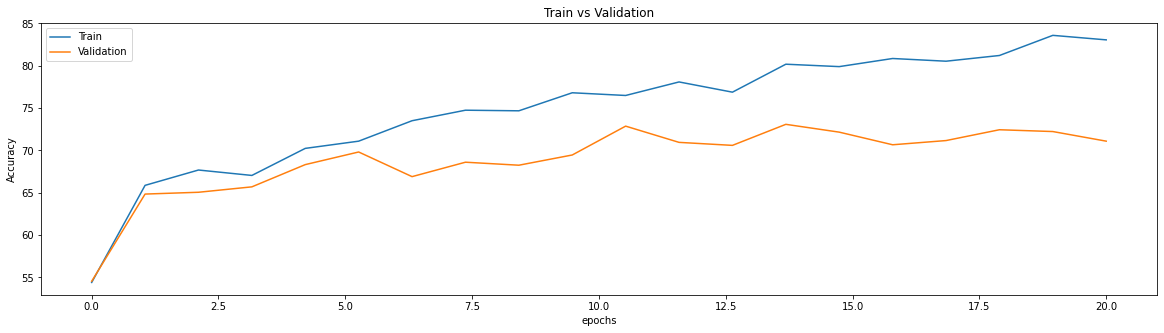

In [ ]:
train_val_comparison(train_accuracy, val_accuracy, len(train_loader))

In [ ]:
def load_checkpoint(filepath):
    checkpoint = torch.load(filepath)
    return checkpoint
checkpoint = load_checkpoint("/content/drive/MyDrive/Colab Notebooks/AI_lab/AI Final Project/checkpoint_denseNet.pth")

In [ ]:
checkpoint.keys()

dict_keys(['model', 'training_accuracy_list', 'val_accuracy_list', 'state_dict'])

In [ ]:
# checkpoint['state_dict']

In [ ]:
Dense_net = torchvision.models.densenet121()
num_filters = Dense_net.classifier.in_features
Dense_net.classifier = torch.nn.Linear(num_filters, 8)
Dense_net.load_state_dict(checkpoint['state_dict'])

optimizer = torch.optim.Adam(params=Dense_net.parameters())
loss = torch.nn.CrossEntropyLoss()

In [ ]:
total, accuracy = evaluate_accuracy(Dense_net, test_loader)

Test Accuracy of the model on the 800 test images: 84.0 %


# Transfer Learning on DenseNet121

In [ ]:
# Model definition and initialization
Dense_net = torch.hub.load('pytorch/vision:v0.10.0', 'densenet121', pretrained= True)
num_filters = Dense_net.classifier.in_features
Dense_net.classifier = torch.nn.Linear(num_filters, 8)
optimizer = torch.optim.Adam(params=Dense_net.parameters())
loss = torch.nn.CrossEntropyLoss()


Downloading: "https://github.com/pytorch/vision/zipball/v0.10.0" to /root/.cache/torch/hub/v0.10.0.zip
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth


  0%|          | 0.00/30.8M [00:00<?, ?B/s]

In [ ]:
print(Dense_net)

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

Training the model

In [ ]:
dense_net_lr, best_model_weights, denseNet_training_accuracy_list, denseNet_val_accuracy_list = train_model(Dense_net, train_loader, val_loader, optimizer, loss, epochs=20)

Device: cuda:0
Epoch [1/20], Train_Loss: 2.2133, Train_Accuracy: 18.75%  Val_Loss: 2.1614, Val_Accuracy: 18.75%
Epoch [1/20], Train_Loss: 2.2338, Train_Accuracy: 12.50%  Val_Loss: 1.8363, Val_Accuracy: 37.50%
Epoch [1/20], Train_Loss: 1.9947, Train_Accuracy: 40.62%  Val_Loss: 1.9824, Val_Accuracy: 31.25%
Epoch [1/20], Train_Loss: 1.5956, Train_Accuracy: 34.38%  Val_Loss: 1.5656, Val_Accuracy: 43.75%
Epoch [1/20], Train_Loss: 1.4329, Train_Accuracy: 56.25%  Val_Loss: 1.3770, Val_Accuracy: 37.50%
Epoch [1/20], Train_Loss: 1.6800, Train_Accuracy: 40.62%  Val_Loss: 1.4673, Val_Accuracy: 43.75%
Epoch [1/20], Train_Loss: 1.2395, Train_Accuracy: 56.25%  Val_Loss: 2.0192, Val_Accuracy: 31.25%
Epoch [1/20], Train_Loss: 1.3151, Train_Accuracy: 56.25%  Val_Loss: 1.3856, Val_Accuracy: 50.00%
Epoch [1/20], Train_Loss: 1.2273, Train_Accuracy: 53.12%  Val_Loss: 1.1464, Val_Accuracy: 68.75%
Epoch [1/20], Train_Loss: 1.1526, Train_Accuracy: 56.25%  Val_Loss: 1.0296, Val_Accuracy: 68.75%
Epoch [1/20], T

# Saving the weights, training and validation values

In [ ]:
checkpoint_denseNet_lr = {'model': dense_net_lr,
         'training_accuracy_list': denseNet_training_accuracy_list,
         'val_accuracy_list': denseNet_val_accuracy_list,
              'state_dict': dense_net_lr.state_dict()}
torch.save(checkpoint_denseNet_lr, '/content/drive/MyDrive/Colab Notebooks/AI_lab/AI Final Project/checkpoint_denseNet_lr.pth')

In [ ]:
train_accuracy, val_accuracy = accuracyForEachEpoch(denseNet_training_accuracy_list), accuracyForEachEpoch(denseNet_val_accuracy_list)

Comparison between train and validation for DenseNet121. The graph suggests that there is  overfitting towards the end.

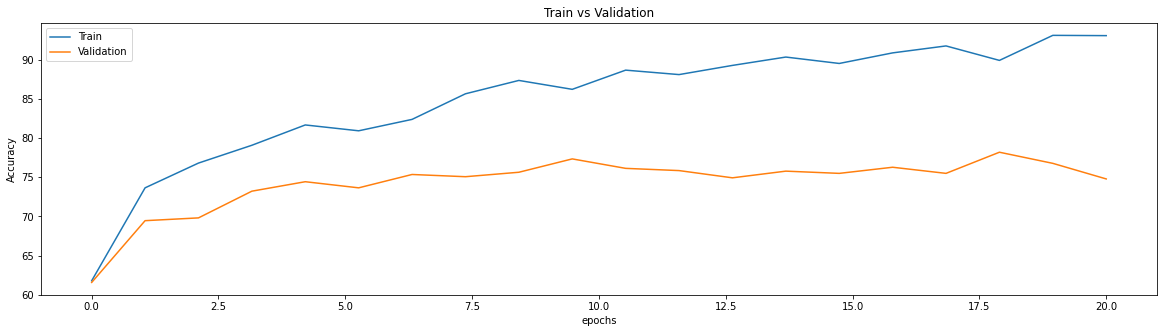

In [ ]:
train_val_comparison(train_accuracy, val_accuracy, len(train_loader), 20)

In [ ]:
def load_checkpoint(filepath):
    checkpoint = torch.load(filepath)
    return checkpoint
checkpoint = load_checkpoint("/content/drive/MyDrive/Colab Notebooks/AI_lab/AI Final Project/checkpoint_denseNet_lr.pth")

In [ ]:
Dense_net = torchvision.models.densenet121()
num_filters = Dense_net.classifier.in_features
Dense_net.classifier = torch.nn.Linear(num_filters, 8)
Dense_net.load_state_dict(checkpoint['state_dict'])

optimizer = torch.optim.Adam(params=Dense_net.parameters())
loss = torch.nn.CrossEntropyLoss()

In [ ]:
total, accuracy = evaluate_accuracy(Dense_net, test_loader)

Test Accuracy of the model on the 800 test images: 92.5 %


# VGG16

In [ ]:
import torch
import torch.nn as nn
import torchvision
from torchvision.models import vgg16, vgg19

In [ ]:
def load_checkpoint(filepath):
    checkpoint = torch.load(filepath)
    return checkpoint
checkpoint = load_checkpoint("/content/drive/MyDrive/Colab Notebooks/AI_lab/AI Final Project/vgg16_eightclass.pth")

In [ ]:
model = torchvision.models.vgg16()
num_features =model.classifier[6].in_features
features = list(model.classifier.children())[:-1] 
features.extend([nn.Linear(num_features, 8)]) 
model.classifier = nn.Sequential(*features)
model.load_state_dict(checkpoint['state_dict'])
optimizer = torch.optim.SGD(params=model.parameters(),lr=0.001)
loss = torch.nn.CrossEntropyLoss()

In [ ]:
total, accuracy = evaluate_accuracy(model, test_loader)

Test Accuracy of the model on the 800 test images: 92.375 %


## HYPER-PARAMTER TUNING


### 1. LEARNING *RATE*

Trying a combination of 5 learning rates on the DenseNet121 to see which learning rate performs the best

In [ ]:
hyper_parameters = {
    "learning_rate": [2, 0.1, 0.01, 0.0025, 0.0001]
}

train_acc_hyper_paramaters = {
    "lr2": 0,
    "lr0.1": 0,
    "lr0.01": 0,
    "lr0.0025": 0,
    "lr0.0001": 0
}

train_val_hyper_paramaters = {
    "lr2": 0,
    "lr0.1": 0,
    "lr0.01": 0,
    "lr0.0025": 0,
    "lr0.0001": 0
}


A loop that runs along the list of 5 learning rates and trains new models with the learning rates. Save the train and validation accuracies in the previously initialized dictionary

In [ ]:
for rate in hyper_parameters["learning_rate"]:
    Dense_net = torch.hub.load('pytorch/vision:v0.10.0', 'densenet121', pretrained=False)
    num_filters = Dense_net.classifier.in_features
    Dense_net.classifier = torch.nn.Linear(num_filters, 8)
    optimizer = torch.optim.Adam(params=Dense_net.parameters(), lr=rate)
    loss = torch.nn.CrossEntropyLoss()
    print(f'Results of the learning rate = {rate}')
    dense_net, best_model_weights, training_accuracy_list, val_accuracy_list = train_model(Dense_net, train_loader, val_loader, optimizer, loss, epochs=7)
    print(f"Train accuracy:{training_accuracy_list}%, Train val:{val_accuracy_list}")
    train_acc_hyper_paramaters[rate], train_val_hyper_paramaters[rate] = training_accuracy_list, val_accuracy_list


Results of the learning rate = 2
Device: cuda:0


Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


Epoch [1/7], Train_Loss: 2.1002, Train_Accuracy: 12.50%  Val_Loss: 1136.5490, Val_Accuracy: 31.25%
Epoch [1/7], Train_Loss: 1469.0293, Train_Accuracy: 15.62%  Val_Loss: 2188.1528, Val_Accuracy: 6.25%
Epoch [1/7], Train_Loss: 1943.4745, Train_Accuracy: 6.25%  Val_Loss: 1474.0520, Val_Accuracy: 18.75%
Epoch [1/7], Train_Loss: 1884.4694, Train_Accuracy: 9.38%  Val_Loss: 1009.2581, Val_Accuracy: 25.00%
Epoch [1/7], Train_Loss: 1403.9120, Train_Accuracy: 25.00%  Val_Loss: 1236.2329, Val_Accuracy: 6.25%
Epoch [1/7], Train_Loss: 594.7198, Train_Accuracy: 18.75%  Val_Loss: 647.5692, Val_Accuracy: 12.50%
Epoch [1/7], Train_Loss: 349.3832, Train_Accuracy: 21.88%  Val_Loss: 875.3824, Val_Accuracy: 6.25%
Epoch [1/7], Train_Loss: 783.1074, Train_Accuracy: 12.50%  Val_Loss: 129.0981, Val_Accuracy: 31.25%
Epoch [1/7], Train_Loss: 325.6379, Train_Accuracy: 21.88%  Val_Loss: 123.7298, Val_Accuracy: 12.50%
Epoch [1/7], Train_Loss: 235.5378, Train_Accuracy: 3.12%  Val_Loss: 47.2727, Val_Accuracy: 31.25%


In [ ]:
for lr in hyper_parameters["learning_rate"]:
  train_acc_hyper_paramaters[f"lr{lr}"], train_val_hyper_paramaters[f"lr{lr}"] = train_acc_hyper_paramaters[lr], train_val_hyper_paramaters[lr]

# Save the paramerter along with the dictionary of train and validation values for further comparison

In [ ]:
hyper_param = {'model': Dense_net,
               'hyper_parameters': hyper_parameters,
               'train_acc_hyper_paramaters': train_acc_hyper_paramaters,
               'train_val_hyper_paramaters': train_val_hyper_paramaters
              }

In [ ]:
torch.save(hyper_param, 'hyper_param.pth')

# Loading train and validation accuracies on tuned ResNet model against batch size.

In [ ]:
def load_checkpoint(filepath):
    checkpoint = torch.load(filepath)
    return checkpoint

In [ ]:
hyperparam = load_checkpoint("/content/drive/MyDrive/AI Final Project/hyper_param_bs (1).pth")

In [ ]:
hyperparam.keys()

dict_keys(['model', 'hyper_parameters', 'train_acc_hyper_paramaters', 'train_val_hyper_paramaters'])

In [ ]:
hyperparam['hyper_parameters']

{'batch_size': [16, 32, 64, 128]}

In [ ]:
hyperparam['train_val_hyper_paramaters'].keys()

dict_keys(['bs16', 'bs32', 'bs64', 'bs128', 16, 32, 64, 128])

In [ ]:
len(hyperparam['train_val_hyper_paramaters']["bs16"])

1050

In [ ]:
acc = {}
for batch in hyperparam['train_val_hyper_paramaters'].keys():
    total = 0
    total = sum(hyperparam['train_val_hyper_paramaters'][batch])/len(hyperparam['train_val_hyper_paramaters'][batch])
    acc[batch] = total
acc

{'bs16': 57.36904761904762,
 'bs32': 58.214962121212125,
 'bs64': 57.05492424242424,
 'bs128': 53.59848484848485,
 16: 57.36904761904762,
 32: 58.214962121212125,
 64: 57.05492424242424,
 128: 53.59848484848485}

/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 4000 samples in 0.038s...
[t-SNE] Computed neighbors for 4000 samples in 4.023s...
[t-SNE] Computed conditional probabilities for sample 1000 / 4000
[t-SNE] Computed conditional probabilities for sample 2000 / 4000
[t-SNE] Computed conditional probabilities for sample 3000 / 4000
[t-SNE] Computed conditional probabilities for sample 4000 / 4000
[t-SNE] Mean sigma: 1377.623714
[t-SNE] KL divergence after 250 iterations with early exaggeration: 70.014915
[t-SNE] KL divergence after 300 iterations: 1.927449


/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/seaborn/_core.py:882: FutureWarning: The input object of type 'Image' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Image', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  val in data


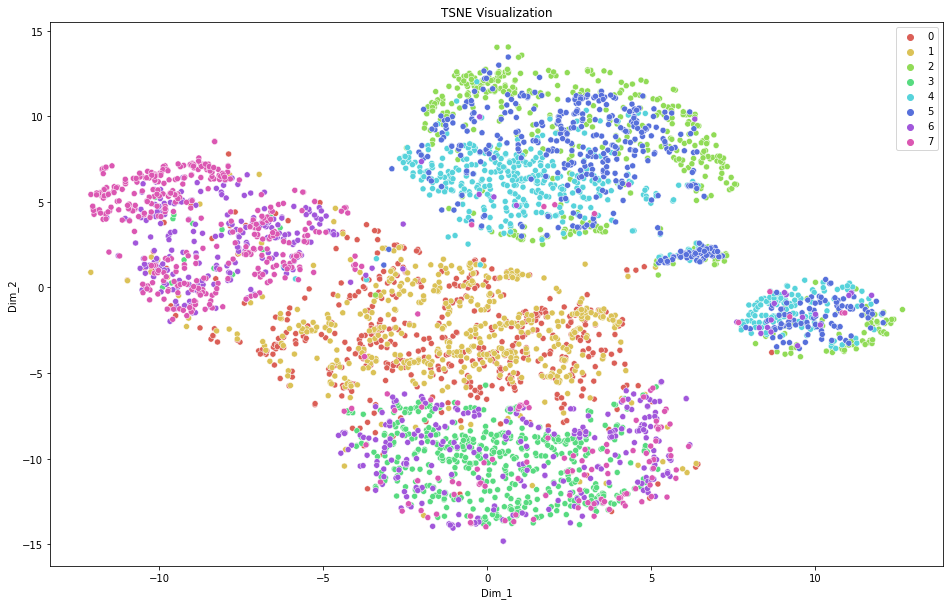

In [10]:
data=datasets.ImageFolder(root=r'/content/drive/MyDrive/AI Final Project/eightClass')
random=0
X=[]
Y=[]
for x,y in data:
                          xrs=x.resize((64,64))
                          img=np.array(xrs).reshape(64*64*3)
                          X.append(img)
                          Y.append(y)
arrX=np.array(X)
arrY=np.array(Y)

from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300).fit_transform(arrX)

import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(16,10))
sns.scatterplot(tsne[:,0],tsne[:,1],hue=Y,palette=sns.color_palette("hls", 8),data=data,legend="full")
# Using Plt.scatter, visualize the transformed data marked with their corresponding label in 2D embedding.
plt.title('TSNE Visualization')
plt.xlabel('Dim_1')
plt.ylabel('Dim_2')
plt.show()
plt.close()

/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 3200 samples in 0.033s...
[t-SNE] Computed neighbors for 3200 samples in 3.314s...
[t-SNE] Computed conditional probabilities for sample 1000 / 3200
[t-SNE] Computed conditional probabilities for sample 2000 / 3200
[t-SNE] Computed conditional probabilities for sample 3000 / 3200
[t-SNE] Computed conditional probabilities for sample 3200 / 3200
[t-SNE] Mean sigma: 1721.128537
[t-SNE] KL divergence after 250 iterations with early exaggeration: 66.943802
[t-SNE] KL divergence after 300 iterations: 1.612680


/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/seaborn/_core.py:882: FutureWarning: The input object of type 'Image' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Image', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  val in data


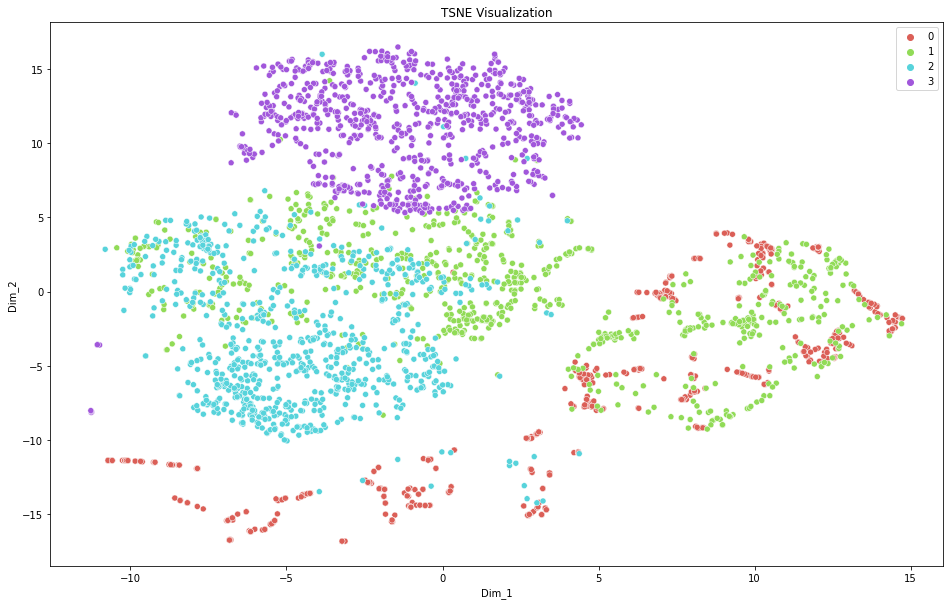

In [13]:
data=datasets.ImageFolder(root=r'/content/drive/MyDrive/AI Final Project/fourClass/train')
random=0
X=[]
Y=[]
for x,y in data:
                          xrs=x.resize((64,64))
                          img=np.array(xrs).reshape(64*64*3)
                          X.append(img)
                          Y.append(y)
arrX=np.array(X)
arrY=np.array(Y)

from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300).fit_transform(arrX)

import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(16,10))
sns.scatterplot(tsne[:,0],tsne[:,1],hue=Y,palette=sns.color_palette("hls", 4),data=data,legend="full")
# Using Plt.scatter, visualize the transformed data marked with their corresponding label in 2D embedding.
plt.title('TSNE Visualization')
plt.xlabel('Dim_1')
plt.ylabel('Dim_2')
plt.show()
plt.close()

/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 10662 samples in 0.102s...
[t-SNE] Computed neighbors for 10662 samples in 26.608s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10662
[t-SNE] Computed conditional probabilities for sample 2000 / 10662
[t-SNE] Computed conditional probabilities for sample 3000 / 10662
[t-SNE] Computed conditional probabilities for sample 4000 / 10662
[t-SNE] Computed conditional probabilities for sample 5000 / 10662
[t-SNE] Computed conditional probabilities for sample 6000 / 10662
[t-SNE] Computed conditional probabilities for sample 7000 / 10662
[t-SNE] Computed conditional probabilities for sample 8000 / 10662
[t-SNE] Computed conditional probabilities for sample 9000 / 10662
[t-SNE] Computed conditional probabilities for sample 10000 / 10662
[t-SNE] Computed conditional probabilities for sample 10662 / 10662
[t-SNE] Mean sigma: 1344.790156
[t-SNE] KL divergence after 250 iterations with early exaggeration: 83.130783
[t-SNE

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/seaborn/_core.py:882: FutureWarning: The input object of type 'Image' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Image', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  val in data


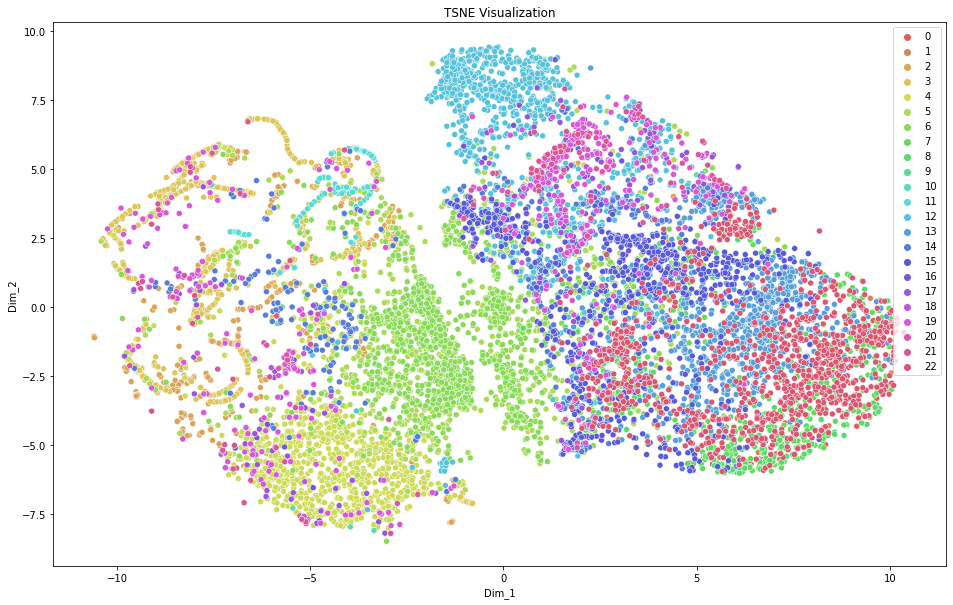

In [15]:
data=datasets.ImageFolder(root=r'/content/drive/MyDrive/AI Final Project/23Class')
random=0
X=[]
Y=[]
for x,y in data:
                          xrs=x.resize((64,64))
                          img=np.array(xrs).reshape(64*64*3)
                          X.append(img)
                          Y.append(y)
arrX=np.array(X)
arrY=np.array(Y)

from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300).fit_transform(arrX)

import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(16,10))
sns.scatterplot(tsne[:,0],tsne[:,1],hue=Y,palette=sns.color_palette("hls", 23),data=data,legend="full")
# Using Plt.scatter, visualize the transformed data marked with their corresponding label in 2D embedding.
plt.title('TSNE Visualization')
plt.xlabel('Dim_1')
plt.ylabel('Dim_2')
plt.show()
plt.close()